# Analisi Dati in Python

Per prima cosa importiamo le librerie che ci serviranno:  

- Numpy per lavorare con gli array, le funzioni matematiche, ma soprattutto per importare file di testo con la funzione *loadtxt()*;

- Matplotlip.Pyplot per la rappresentazione grafica;

- Da Scipy.Optimize importeremo la funzione *curve_fit()*,la quale ci consentirà di eseguire regressioni di qualunque tipo (lineari, esponenziali, etc...).

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# opzionale, a me piace lo stile che da ai grafici di matplotlib,
# per installarla con anaconda usare il comando qua sotto nell'anaconda prompt:
#  conda install conda-forge::scienceplots

import scienceplots
plt.style.use(['science', 'notebook'])

## Primo Sguardo a *curve_fit()*

Per prima cosa definiamo la funzione che vogliamo utilizzare, in questo caso una semplice retta.  

NB: quando definiamo la funzione è necessario che le x, variabili indipendenti, siano inserite nelle parentesi PRIMA degli altri parametri da fittare.

In [2]:
##NOTE: prima le x e poi i parametri

def f(x, A, B):
    return A*x + B

Creiamo ora una serie di dati in *x* per poi darli in pasto alla funzione per ottenere le relative *y*, in questo caso abbiamo creato una retta  
con coefficiente angoalre *1* ed intercetta con l'asse delle y pari a *-2*

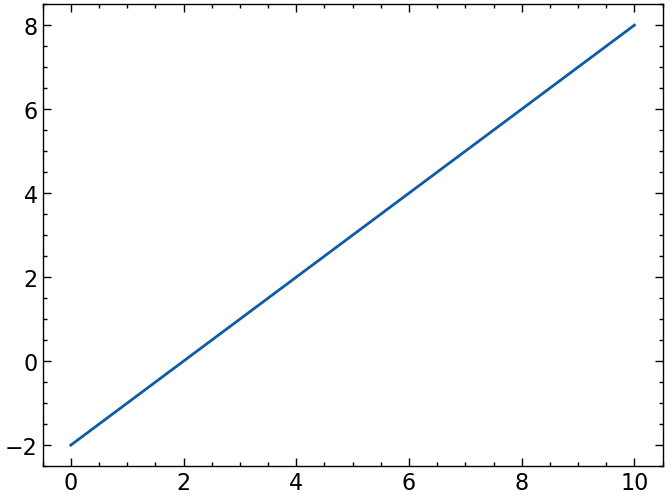

In [3]:
x = np.linspace(0, 10, 25)
y = f(x, 1, -2)

#visualizziamo la retta appena creata
plt.plot(x, y)

Dato che il nostro scopo è fittare dei dati non ha semso mantenere le y come definite prima, in quanto sono prive di errori.  

Sfruttiamo Numpy per creare dei numeri distribuiti gaussianamente che simuleranno gli errori casuali incontrati durante unu esperimento reale

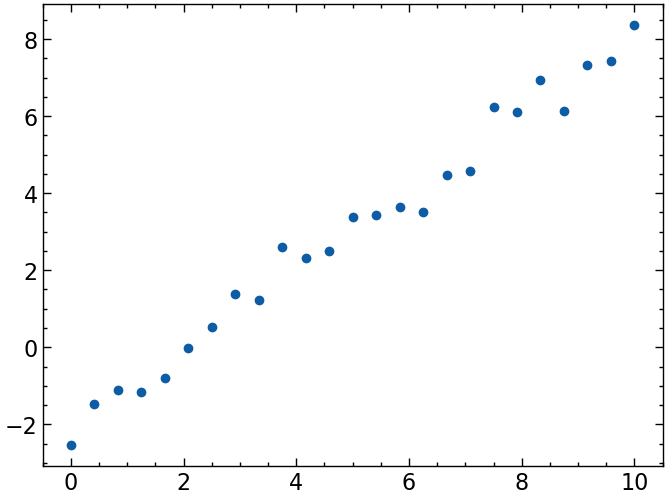

In [4]:
# size specifica quanti punti vogliamo generare e scale la deviazione standard
err = np.random.normal(size=25, scale=0.5)
y_err = y + err

#visualizziamo i dati appena creati con uno scatterplot
plt.scatter(x, y_err)

Una volta generati gli errori ed aggiunti alle nostre y possiamo procedere a fittare i dati con *curve_fit()*.  

La funzione richiede i seguenti parametri:

- La funzione che vogliamo fittare, nel nostro caso una retta;

- I dati delle x in formato array o lista;

- I dati delle y in formato array o lista;

- Opzionale: un array contenente le nostre guess iniziali dei parametri da fittare, molto utile nel caso di relazioni  
complicate per "aiutare" curve_fit ad andare a convergenza.

La funzione ci restituisce due array che noi associeremo alle variabili *popt (optimal parameter)* e *pcov (parameter covariance)*.

In [5]:
popt, pcov = curve_fit(f, x, y_err)

L'array *popt* contiene i valori dei parametri della nostra funzione che curve_fit ha calcolato.

In [6]:
popt

array([ 1.02124556, -2.10696332])

L'array *pcov* è un po' più delicato: consiste nella matrice delle covarianze dei parametri.  

In generale questa matrice sarà *N_parametri X N_parametri*:

$$
pcov = \left(\begin{array}{cc} 
\sigma_1 \sigma_1 & \sigma_1 \sigma_2 & ... & \sigma_1 \sigma_N\\
\sigma_2 \sigma_1 & \sigma_2 \sigma_2 & ... & \sigma_2 \sigma_N\\
. & . &  & .\\
. &  & . & .\\
\sigma_N \sigma_1 & \sigma_N \sigma_2 & ... & \sigma_N \sigma_N\\
\end{array}\right)
$$ 

Nel nostro caso in cui i parametri sono 2 (A e B) avremo:

$$
pcov = \left(\begin{array}{cc} 
\sigma_A^2 & \sigma_A \sigma_B\\
\sigma_B \sigma_A & \sigma_B^2\\
\end{array}\right)
$$ 

In [7]:
pcov

array([[ 0.00079624, -0.00398118],
       [-0.00398118,  0.02709415]])

Dato che siamo interessati ai soli errori su A e B, ci serviranno solo gli elementi in diagonale dei quali dovremo fare la radice quadrata.

In [8]:
# array degli errori
errs = np.sqrt(np.diag(pcov))

# associamo tali errori a due variabili
A_err, B_err = errs

Perfetto, ora abbiamo tutti gli ingredienti che ci servono per visualizzare il nostro fit.  

Per primna cosa creiamo i valori delle y con i parametri A e B retituiti dal fit (non i nostri iniziali):

In [9]:
# associamo i due valori fittati a delle variabili
A_fit, B_fit = popt

# calcoliamo le y del fit
y_fit = f(x, A_fit, B_fit)

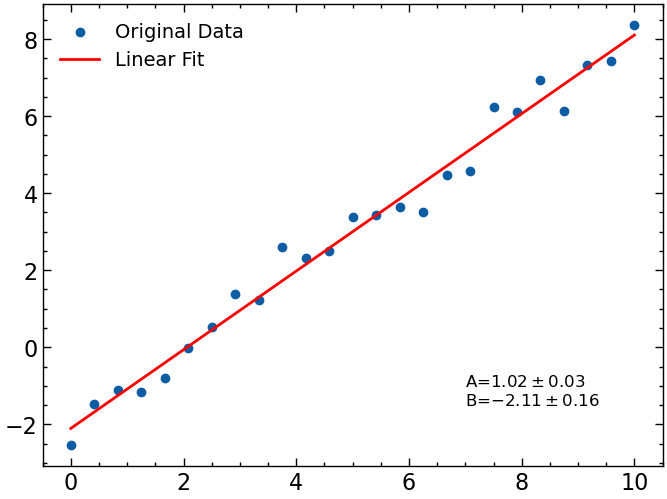

In [10]:
# facciamo di nuovo uno scatterplot dei dati originali
plt.scatter(x, y_err, label='Original Data')

# plottiamo il nostro fit
plt.plot(x, y_fit, color='red', label="Linear Fit")

# aggiungiamo i valori dei parametri con i relativi errori al grafico
# usiamo $$ per scrivere in LaTex e \\pm per il più o meno
plt.text(x=7, y=-1.5, s=f'A=${A_fit:.2f}\\pm{A_err:.2f}$\nB=${B_fit:.2f}\\pm{B_err:.2f}$', fontsize=12)

# mostriamo la legenda
plt.legend(fontsize=14)

Abbiamo finito!  

Ora proveremo con dei veri dati che seguono relazioni non lineari.

## Fit Accelerazione di Gravità

In questo esperimento del primo anno ho misurato la posizione spaziale di una pallina in funzione del tempo.  

Dato che essa partiva da ferma l'equazione che vogliamo fittare è la seguente:

$$S(t) = \frac{1}{2} g t^2$$

Per prima cosa carichiamo i dati con la funzione *loadtxt* di Numpy, il file contiene due righe che non ci interessano: la prima con il titolo  
delle colonne e la seconda con uno spazio vuoto, saltiamole con la keyword *skiprows*

### Attenzione!
Per utenti Windows è necessario specificare il percorso intero del file e mettere una *r* prima della stringa.  
Ciò è dovuto al fatto che Windows usa i backslash (\) per separare le cartelle nei percorsi, ma questo simbolo viene usato  
anche per andare a capo (\n) o per lasciare una tabulazione (\t). La *r* dice a Python di considerare qualunque simbolo  
all'interno della stringa come letterale, ovvero senza associarlo ad un comando

In [12]:
data = np.loadtxt('exp_g.txt', skiprows=2)

Ora che abbiamo caricato i dati scriviamo la funzione che vogliamo fittare

In [13]:
def f_gravit(x, G):
    return 0.5 * G * x**2

Associamo la colonna dei tempi alle *x* e quella delle posizioni alle *y* ed eseguiamo il fit con *curve_fit*

In [14]:
x_g = data[:,0]
y_g = data[:,1]

popt_g, pcov_g = curve_fit(f_gravit, x_g, y_g)

Associamo valore di *g* e suo errore a delle variabili

In [15]:
g_fit = popt_g[0]

g_err = np.sqrt(np.diag(pcov_g))
g_err

array([0.11914383])

In [16]:
# NB: pur essendo un solo valore g__err resta un array, dobbiamo quindi prendere il primo (e unico) elemento
g_err = g_err[0]
g_err

np.float64(0.11914382947453393)

Calcoliamo le *y* con il valore di *g* restuito dal fit

In [17]:
y_fit_g = f_gravit(x_g, g_fit)

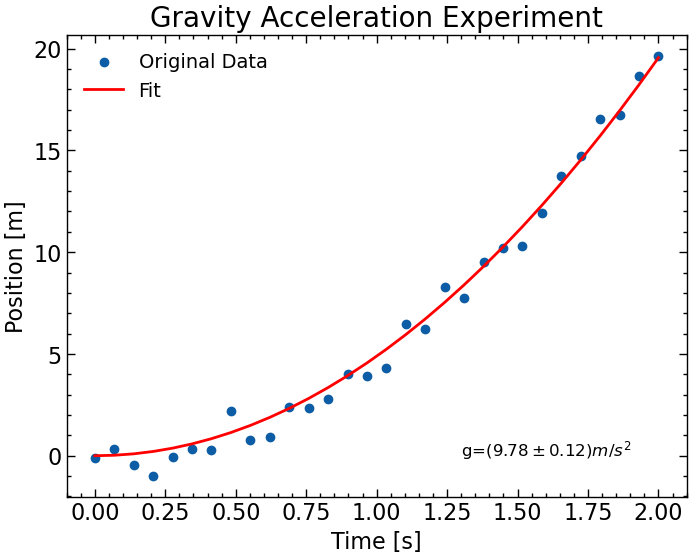

In [18]:
# plottiamo dati e fit come prima

plt.scatter(x_g, y_g, label='Original Data')
plt.plot(x_g, y_fit_g, color='r', label='Fit')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Gravity Acceleration Experiment', fontsize=20)

plt.text(x=1.3, y=0, s=f'g=$({g_fit:.2f}\\pm{g_err:.2f})m/s^2$', fontsize=12)

plt.legend(fontsize=14)

In [19]:
gauss_data = np.loadtxt('gauss.txt', skiprows=2)

In [20]:
x_gauss = gauss_data[:,0]
y_gauss = gauss_data[:,1]

In [21]:
def gauss(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

In [31]:
popt_gauss, pcov_gauss = curve_fit(gauss, x_gauss, y_gauss, p0=[1, 0, 1], bounds=([0, -np.inf, 0], [np.inf, np.inf, np.inf]))
A_fit, mu_fit, sigma_fit = popt_gauss
y_fit_gauss = gauss(x_gauss, A_fit, mu_fit, sigma_fit)
errs = np.sqrt(np.diag(pcov_gauss))
A_err, mu_err, sigma_err = errs

Text(3.5, 0.6, '$\\mu$=$2.40\\pm0.01$\n$\\sigma$=$0.19\\pm0.01$')

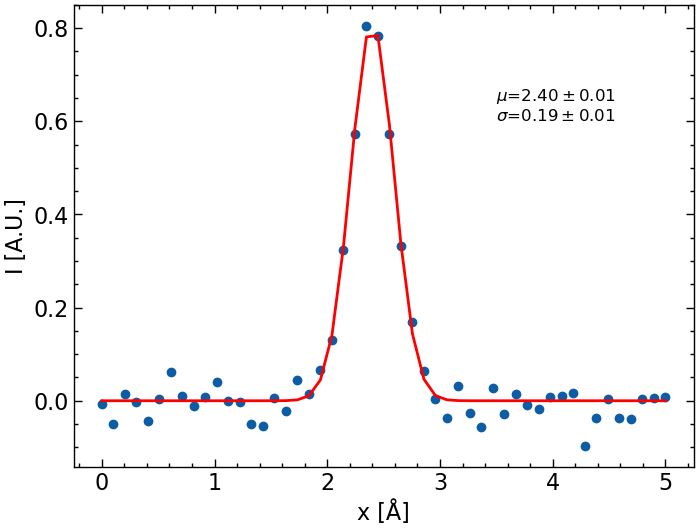

In [42]:
plt.scatter(x_gauss, y_gauss, label='Original Data')
plt.plot(x_gauss, y_fit_gauss, color='r', label='Gaussian Fit')
plt.xlabel('x [Å]')
plt.ylabel('I [A.U.]')

plt.text(x=3.5, y=0.6, s=f'$\\mu$=${mu_fit:.2f}\\pm{mu_err:.2f}$\n$\\sigma$=${sigma_fit:.2f}\\pm{sigma_err:.2f}$', fontsize=12)

## Altri Dataset

Se volete fare pratica con il fitting dei dati ci sono altri due dataset nella cartella:

- *dati_attenuazione.txt* contiene dei dati relativi ad un fascio di fotoni $\gamma$ incidenti su lastre di Tungsteno sempre più spesse,  
lo scopo dell'esperimento consiste nello stimare il coefficiente di attenuazione lineare $\mu$;

- *gauss.txt* contiene dei dati relativi ad un esperimento con un Microscopio ad Effetto Tunnel che raccoglie dati relativi alla  
densità elettronica attorno ad un atomo (nel mio caso si trattava di Grafene e, quindi, Carbonio). Lo scopo dell'esperimento  
consiste nel fittare i dati con una funzione gaussiana, stimanto centro e deviazione standard.

Buon lavoro ;-)